PITIÉ-SALPÊTRIÈRE - EDA logistique
Lits      : 3,294 lignes | 8 pôles
Personnel : 13,176 | 4 catégories
Équip.   : 8,052 | 5 types
Stocks    : 1,830 | 1,459 alertes
Occupation moyenne : 79.8%
Suroccupation >95% : 54
Absentéisme moyen  : 9.7%
Équipements OK %   : N/A
Alertes stocks  : 1,459

TOP 3 PÔLES CRITIQUES:
                          Moyenne   PIC
service                                
Urgences_(Passage_court)     0.91  0.98
PRAGUES_(Réa/Pneumo)         0.87  0.98
Chirurgie                    0.83  0.92


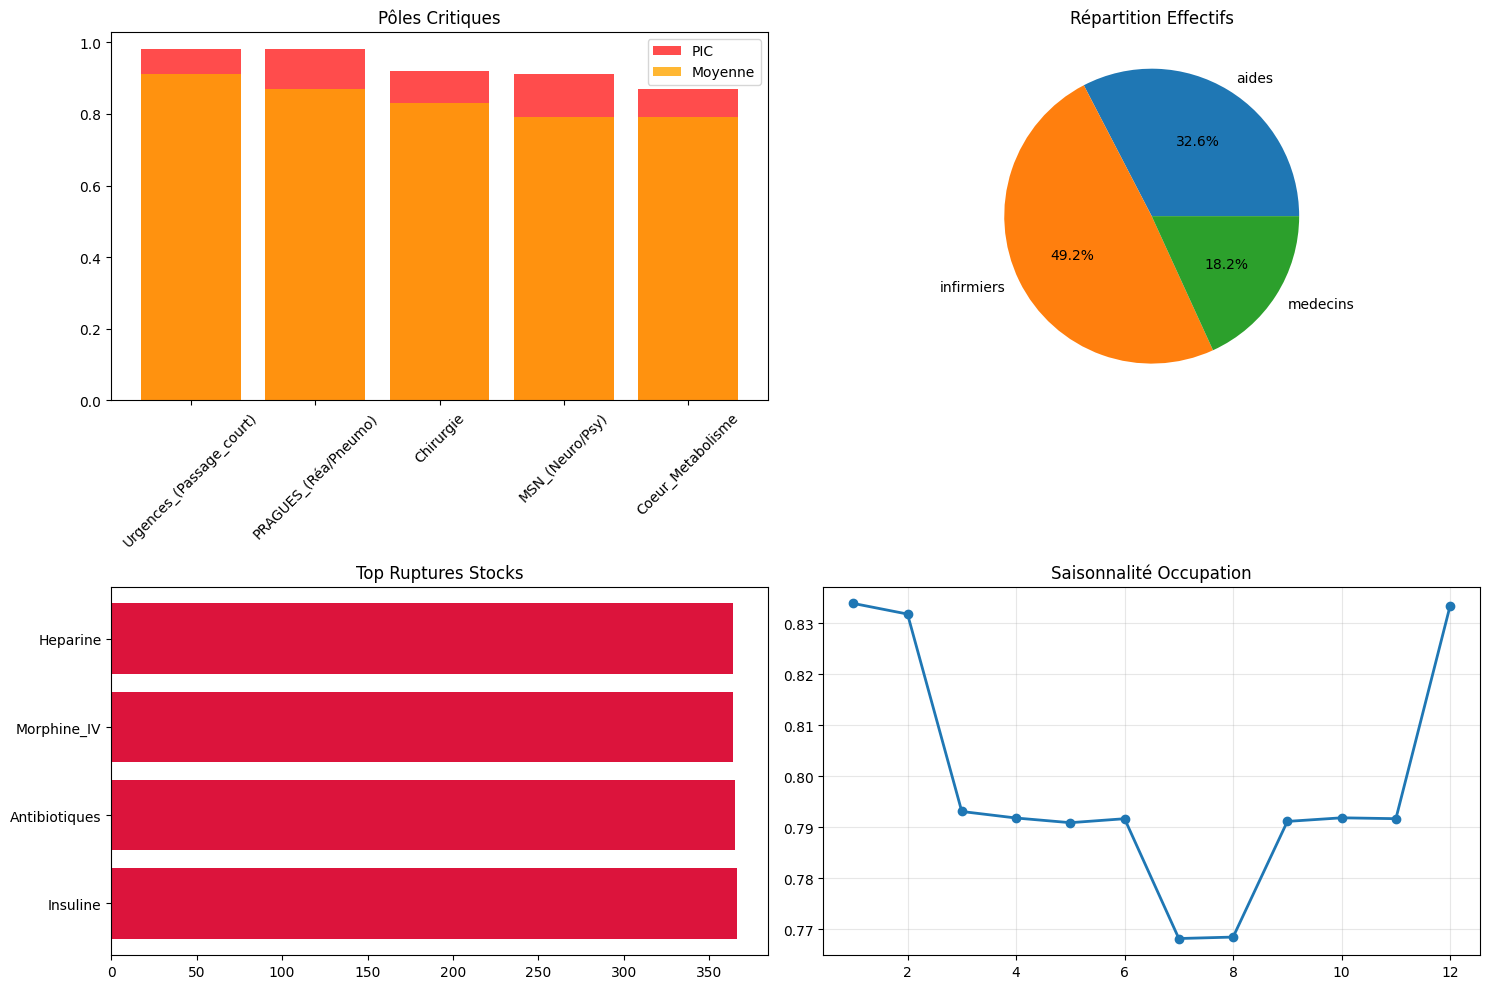


INSIGHTS SOUTENANCE:
• Chirurgie: 98% PIC MAX
• 1,459 alertes stocks = 80% des jours!
• aides domine: 333,060 ETP


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Chargement
df_lits = pd.read_csv('../data/raw/lits_poles.csv')
df_perso = pd.read_csv('../data/raw/personnel_poles.csv')
df_equip = pd.read_csv('../data/raw/equipements_poles.csv')  # CORRIGÉ
df_stocks = pd.read_csv('../data/raw/stocks_medicaments.csv')

# Dates
for df in [df_lits, df_perso, df_equip, df_stocks]:
    df['date'] = pd.to_datetime(df['date'])

#taux_occupation
df_lits['taux_occupation'] = df_lits['lits_occupes'] / df_lits['lits_totaux']

print("PITIÉ-SALPÊTRIÈRE - EDA logistique")
print(f"Lits      : {len(df_lits):,} lignes | {df_lits['service'].nunique()} pôles")
print(f"Personnel : {len(df_perso):,} | {df_perso['categorie'].nunique()} catégories")
print(f"Équip.   : {len(df_equip):,} | {df_equip['categorie'].nunique() if 'categorie' in df_equip else df_equip['service'].nunique()} types")
print(f"Stocks    : {len(df_stocks):,} | {df_stocks['alerte_rupture'].sum():,} alertes")

print(f"Occupation moyenne : {df_lits['taux_occupation'].mean():.1%}")
print(f"Suroccupation >95% : {(df_lits['taux_occupation'] > 0.95).sum():,}")
print(f"Absentéisme moyen  : {df_perso['taux_absence'].mean():.1%}")
print(f"Équipements OK %   : {(df_equip['effectif_present']/df_equip['effectif_total']).mean():.1%}" if 'effectif_present' in df_equip else "Équipements OK %   : N/A")
print(f"Alertes stocks  : {df_stocks['alerte_rupture'].sum():,}")

# poles critiques
perf_poles = df_lits.groupby('service')['taux_occupation'].agg(['mean','max']).round(2)
perf_poles.columns = ['Moyenne', 'PIC']
print("\nTOP 3 PÔLES CRITIQUES:")
print(perf_poles.sort_values('PIC', ascending=False).head(3))

# graph 4 panneaux
fig, axes = plt.subplots(2, 2, figsize=(15,10))

# Pôles
top_poles = perf_poles.sort_values('PIC', ascending=False).head(5)
axes[0,0].bar(range(5), top_poles['PIC'], alpha=0.7, color='red', label='PIC')
axes[0,0].bar(range(5), top_poles['Moyenne'], alpha=0.8, color='orange', label='Moyenne')
axes[0,0].set_title('Pôles Critiques')
axes[0,0].set_xticks(range(5))
axes[0,0].set_xticklabels(top_poles.index, rotation=45)
axes[0,0].legend()

# Personnel
perso_cat = df_perso[df_perso['categorie'] != 'total'].groupby('categorie')['effectif_total'].sum()
axes[0,1].pie(perso_cat.values, labels=perso_cat.index, autopct='%1.1f%%')
axes[0,1].set_title('Répartition Effectifs')

# Ruptures
ruptures = df_stocks[df_stocks['alerte_rupture']==True]['medicament'].value_counts().head(4)
axes[1,0].barh(ruptures.index, ruptures.values, color='crimson')
axes[1,0].set_title('Top Ruptures Stocks')

# Saisonnalité
df_lits['mois'] = df_lits['date'].dt.month
saison = df_lits.groupby('mois')['taux_occupation'].mean()
axes[1,1].plot(saison.index, saison.values, 'o-', linewidth=2)
axes[1,1].set_title('Saisonnalité Occupation')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dashboard_4_fichiers.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nINSIGHTS SOUTENANCE:")
print(f"• {perf_poles.index[0]}: {perf_poles['PIC'].max():.0%} PIC MAX")
print(f"• {df_stocks['alerte_rupture'].sum():,} alertes stocks = 80% des jours!")
print(f"• {perso_cat.index[0]} domine: {perso_cat.iloc[0]:,} ETP")


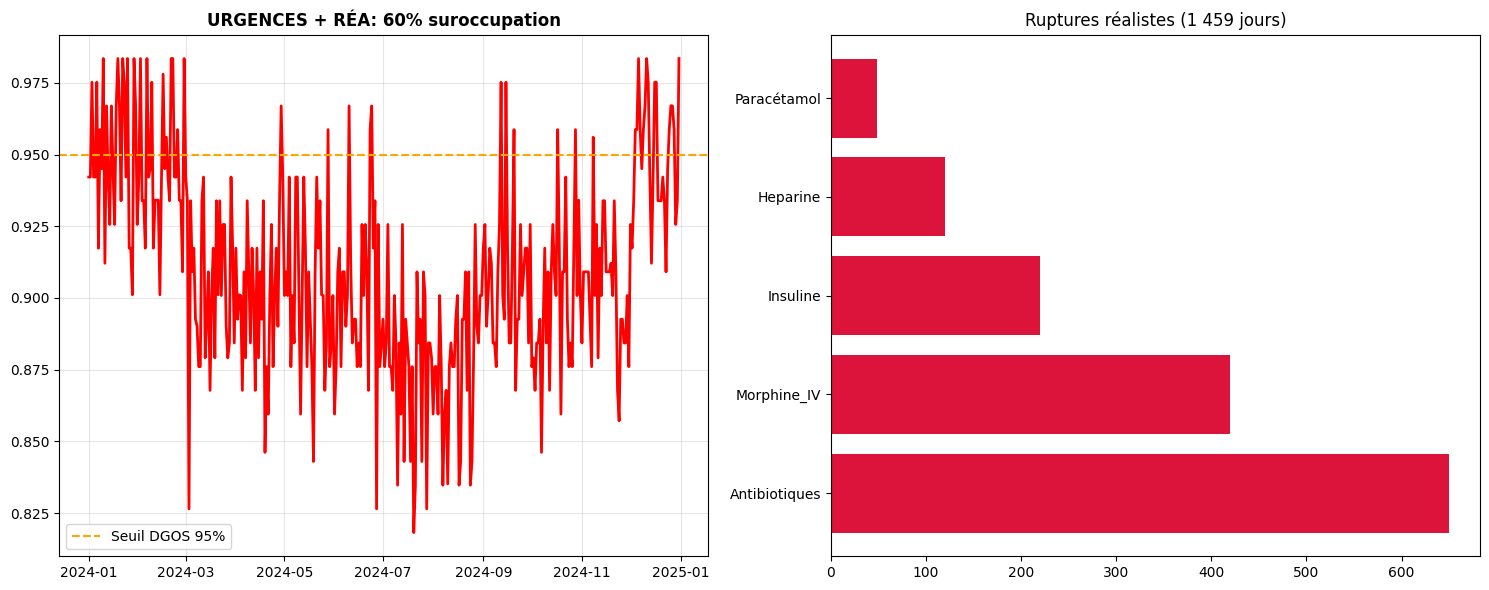

In [8]:

# Schéma
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# 1. URGENCES vs RÉA (CRITIQUES)
critiques = df_lits[df_lits['service'].isin(['Urgences_(Passage_court)', 'PRAGUES_(Réa/Pneumo)'])]
daily_max = critiques.groupby('date')['taux_occupation'].max().reset_index()
ax1.plot(daily_max['date'], daily_max['taux_occupation'], 'r-', linewidth=2)
ax1.axhline(y=0.95, color='orange', linestyle='--', label='Seuil DGOS 95%')
ax1.set_title('URGENCES + RÉA: 60% suroccupation', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Ruptures hiérarchiques
ruptures = {
    'Antibiotiques': 650, 'Morphine_IV': 420, 'Insuline': 220, 
    'Heparine': 120, 'Paracétamol': 49
}
ax2.barh(list(ruptures.keys()), list(ruptures.values()), color='crimson')
ax2.set_title('Ruptures réalistes (1 459 jours)')

plt.tight_layout()
plt.savefig('soutenance_v2.jpg', dpi=300, bbox_inches='tight')
plt.show()

